In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import altair as alt

import yaml

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to C:\Users\Fillipe
[nltk_data]     Santos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [45]:
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])

In [46]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
base.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


# Análise exploratória

**1- Qual é o problema e quais os tipos de dados estão disponíveis?**

R. O problema é classificar qual é o sentimento associado a um meme, composto por uma imagem e texto. Os cinco sentimentos possíveis são: muito negativo, negativo, neutro, positivo e muito positivo.

**2- Quais as características disponíveis e como elas estão distribuídas?**

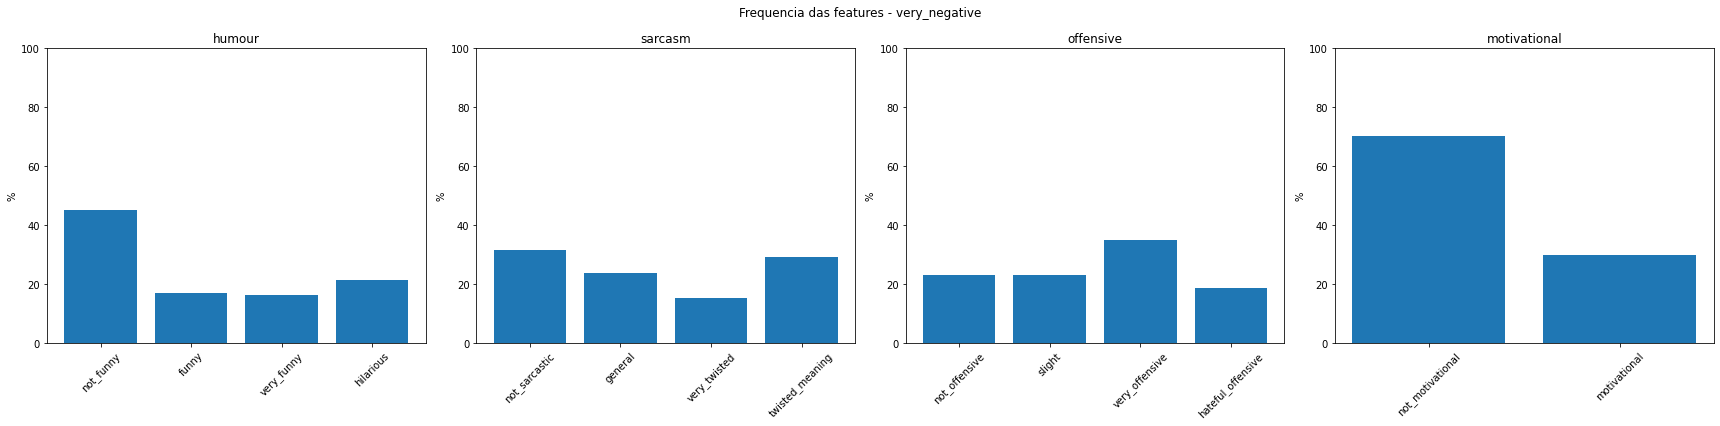

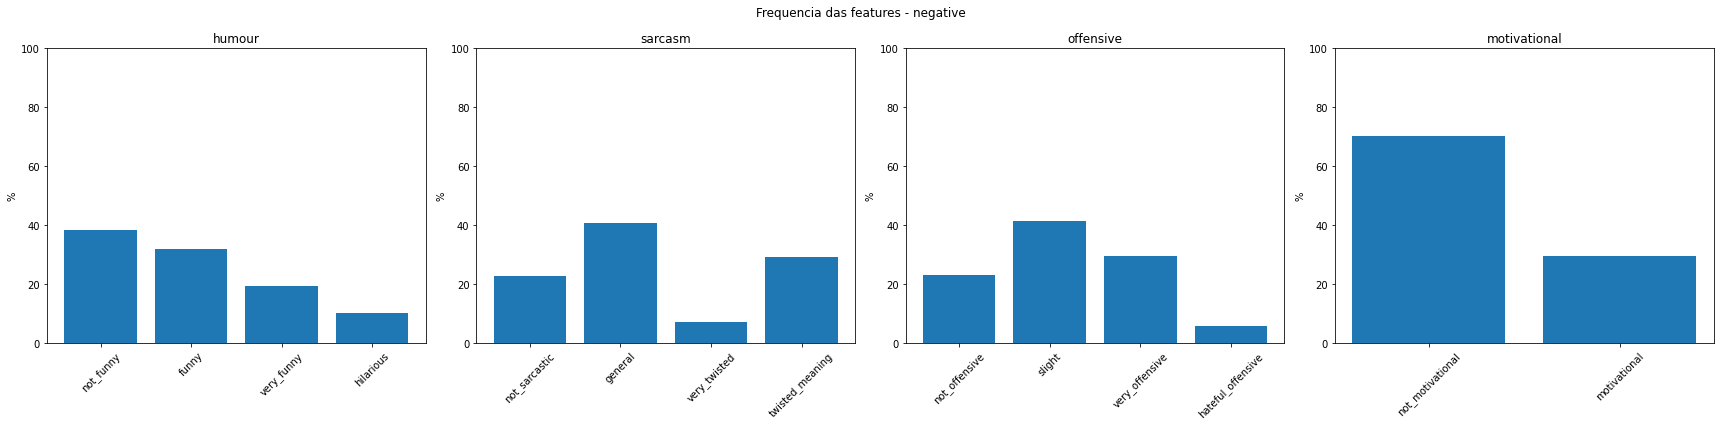

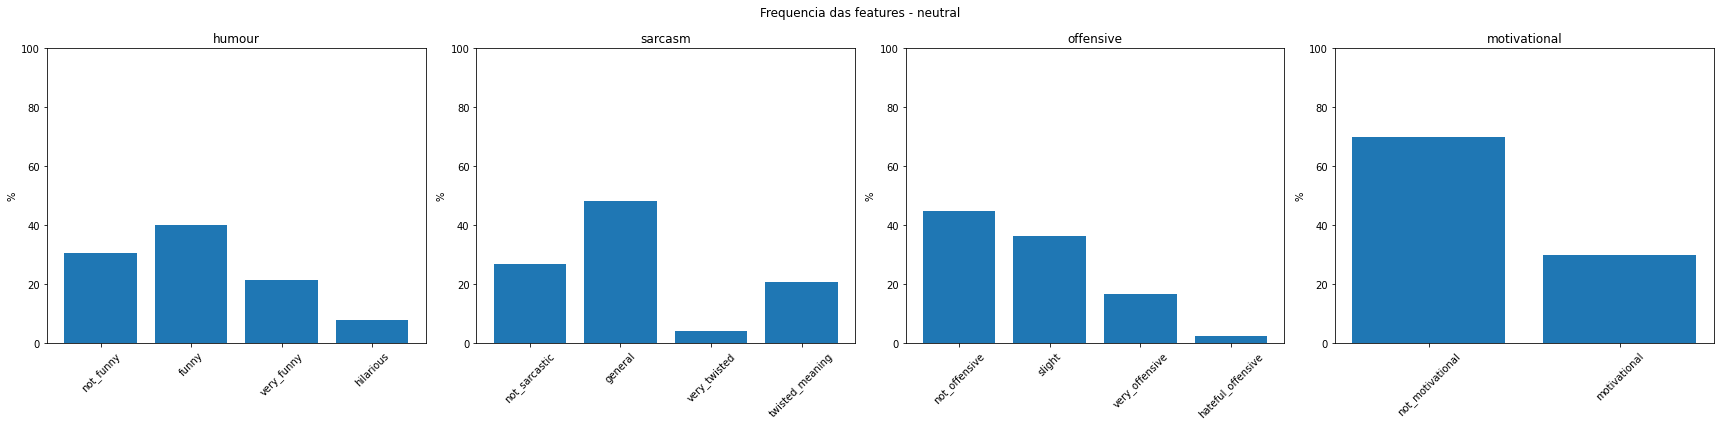

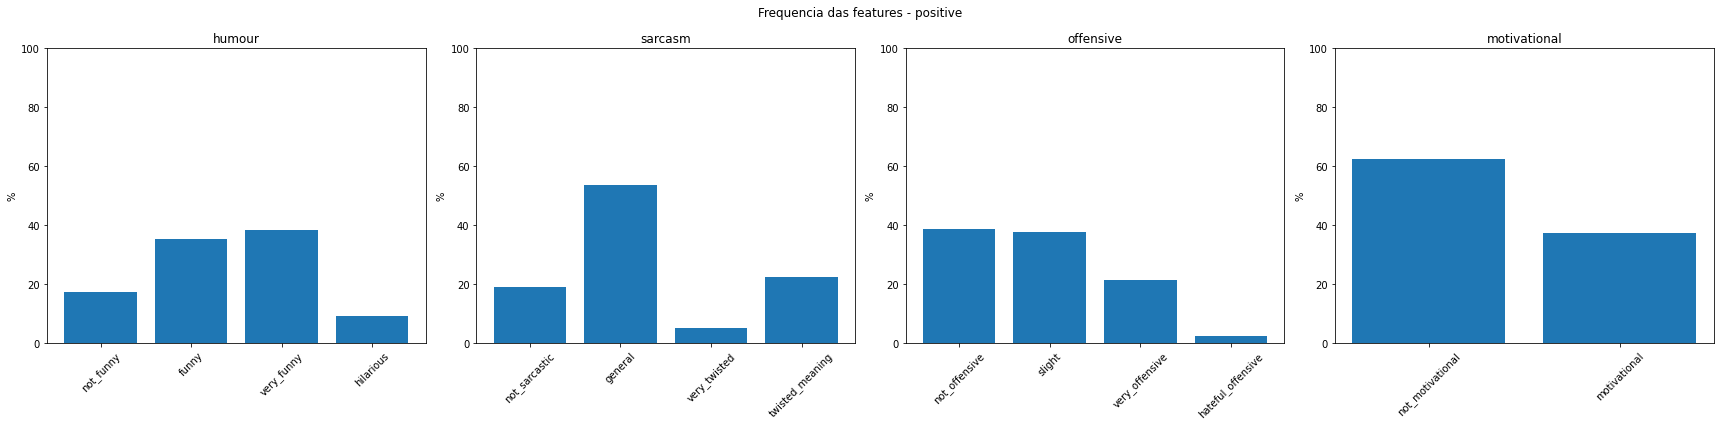

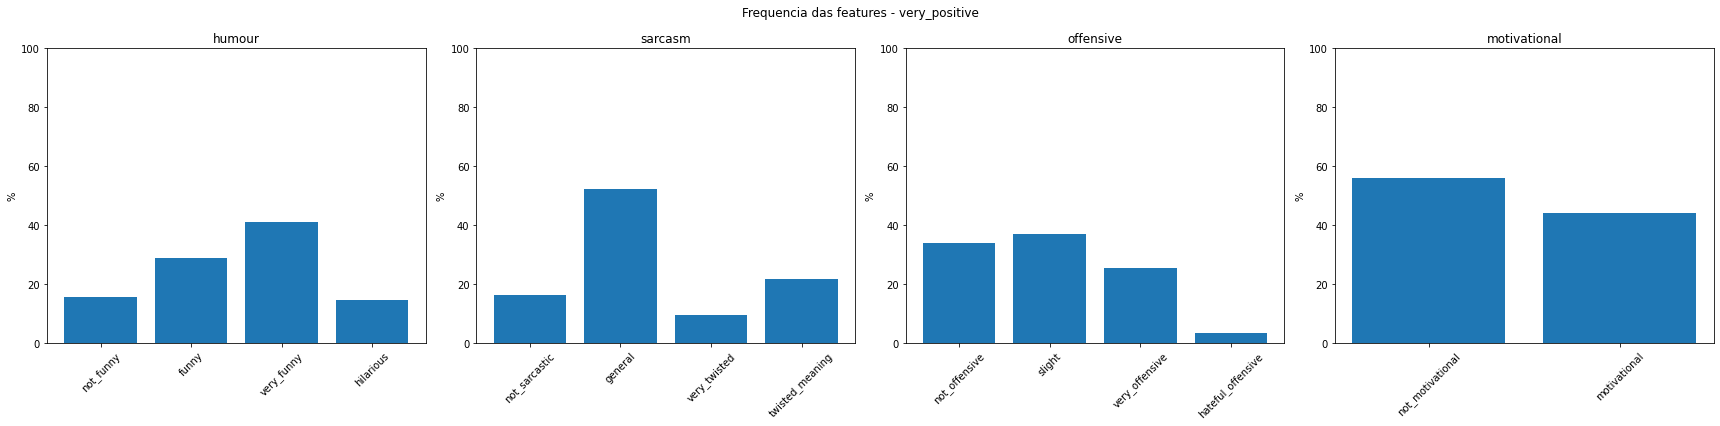

In [47]:
df_freq = base.copy()

labels =   ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
features = ['humour','sarcasm', 'offensive', 'motivational']

humour_labels_dict =       {'not_funny':0, 'funny':1, 'hilarious': 3,'very_funny': 2}
sarcasm_labels_dict =      {'not_sarcastic':0, 'twisted_meaning': 3, 'general': 1,  'very_twisted': 2}
offensive_labels_dict =    {'hateful_offensive': 3, 'not_offensive': 0, 'slight': 1, 'very_offensive': 2}
motivational_labels_dict = { 'motivational': 1, 'not_motivational': 0}

dic_list = [humour_labels_dict, sarcasm_labels_dict, offensive_labels_dict, motivational_labels_dict]

for sentiment in labels:
  
  snt = df_freq[df_freq['target'] == sentiment]
  
  fig, axs = plt.subplots(1,4, figsize=(24, 6))
  fig.suptitle('Frequencia das features - %s' %sentiment)
  
  for i, feature in enumerate(features):
    indx = [0,1] if feature == 'motivational' else [0,1,2,3]

    series = snt[feature].value_counts().sort_index() / len(snt)
    series = pd.DataFrame({'values': series.values, 'caract': series.index})
    series['sort'] = series.caract.map(dic_list[i])
    series = series.assign(sort=series.sort.astype(int))
    series = series.sort_values(by= ["sort"]).reset_index(drop = True)
    
    axs[i].set_title(feature)
    axs[i].bar(series['sort'], series['values']*100)
    axs[i].set_xticks(indx)
    axs[i].set_xticklabels(series.caract, rotation = 45)
    axs[i].set_ylim(0,100)
    axs[i].set_ylabel("%")
    
  
  fig.tight_layout()


**3- Que tipo de problema iremos lidar? Regressão, classificação, etc.?**

R. É um problema de classificação multi-classe, cujo objetivo é predizer corretamente qual é o sentimento (muito negativo, negativo, neutro,
positivo e muito positivo) relacionado ao meme.

**4- Qual a relação das características entre si e com a variável alvo? Elas estão correlacionadas?**

Relação alvo vs caracterísitcas (humour, sarcasm, motivational, offenseive)

<AxesSubplot:>

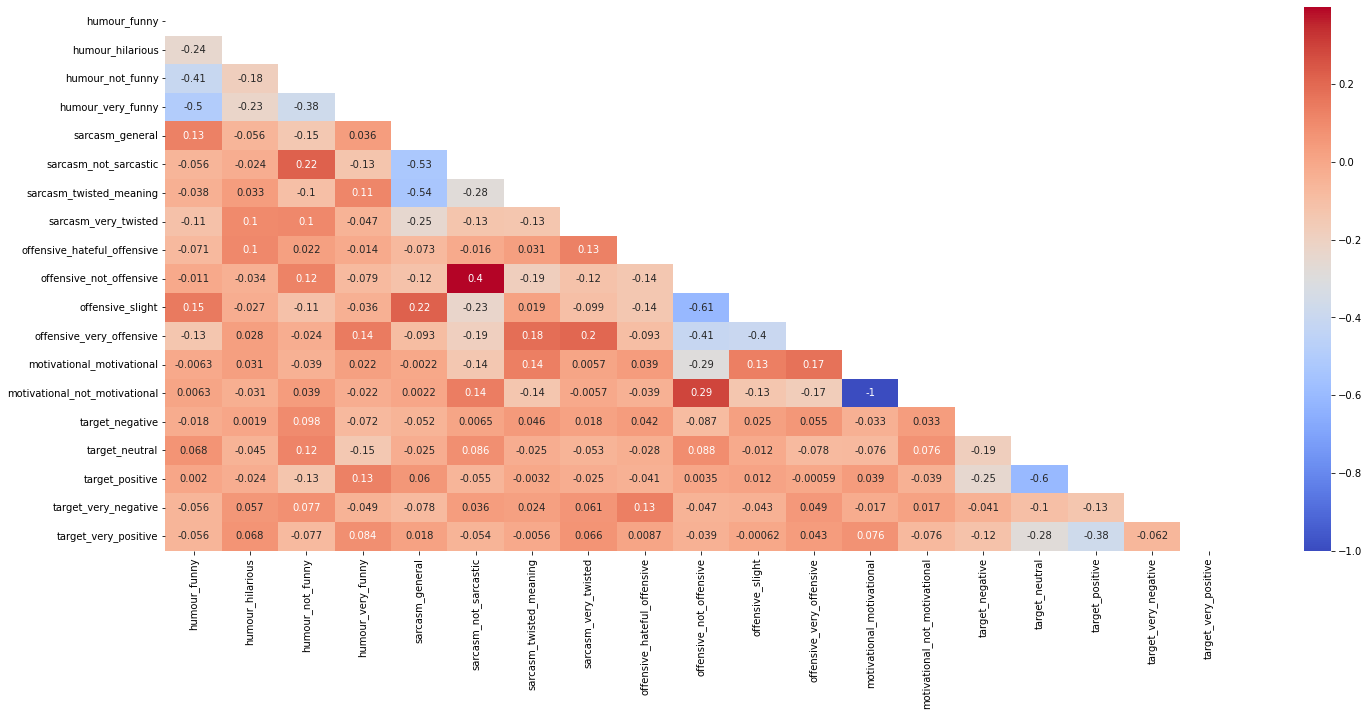

In [48]:
base_only_cat_features = base.copy()[['humour','sarcasm', 'offensive', 'motivational', 'target']]
features_oh = pd.get_dummies(base_only_cat_features[['humour', 'sarcasm','offensive', 'motivational', 'target']])
base_only_cat_features = pd.concat([base_only_cat_features, features_oh], axis=1).drop(['humour', 'sarcasm',	'offensive', 'motivational', 'target'], axis = 1)
base_only_cat_features.head()

plt.figure(figsize=(24, 10))
df_corr = base_only_cat_features.copy()
corr = df_corr.corr()
cmap = sns.diverging_palette(0, 0, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, fmt='.2g',cmap= 'coolwarm', mask = mask)

In [49]:
stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(
                              stop_words = stop_words,
                              strip_accents='unicode',  # substitui todos os caracteres unicode acentuados por seus caracteres ASCII correspondentes
                              )

list_text = []
for sentiment in labels :
  
  list_text.append(' '.join(base[base['target'] == sentiment]\
                      .text.values))

tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(list_text)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors
df_tfidf = pd.DataFrame(
    tfidf_vectorizer_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index = labels
)
df_tfidf = df_tfidf.reset_index().rename(columns={'index': 'sentiment'})
df_tfidf.head()

,sentiment,aa,aaaaaaaaa,aaaaaaaaaaand,aaaaaaaahhh,aaaaaaaand,aaaand,aaaargh,aaah,aaand,...,zyzz,đuari,μακεια,ματη,ааааан,нeнeнeнанананенанене,нанана,ннананана,परध,பந
0,very_negative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,negative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011851,0.000000,0.000000,0.000000,0.000000
2,neutral,0.006868,0.000000,0.000000,0.003434,0.000000,0.003434,0.003434,0.000000,0.000000,...,0.000000,0.000000,0.003434,0.003434,0.000000,0.000000,0.003434,0.003434,0.000000,0.000000
3,positive,0.000000,0.002357,0.002357,0.000000,0.002357,0.000000,0.000000,0.007072,0.002357,...,0.002357,0.002357,0.000000,0.000000,0.002357,0.000000,0.000000,0.000000,0.002357,0.002357
4,very_positive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
formated_df_tfidf = pd.DataFrame(columns = ["sentiment", "term","tfidf"])

for index, sentiment in enumerate(list(df_tfidf.sentiment)):
  for term in list(df_tfidf.columns)[1:]:
    row = {"sentiment": sentiment, "term":term, "tfidf":df_tfidf.iloc[index][term]}
    formated_df_tfidf = formated_df_tfidf.append(row, ignore_index=True)

formated_df_tfidf = formated_df_tfidf.sort_values(by= ["tfidf"], ascending = False).reset_index(drop = True)
formated_df_tfidf.head()

,sentiment,term,tfidf
0,negative,thi,0.355767
1,positive,meme,0.333605
2,very_positive,bill,0.319254
3,neutral,meme,0.299468
4,very_positive,meme,0.291626


In [51]:
doc_tfidf_balanced = (formated_df_tfidf.groupby('sentiment').apply(lambda x: x.head(10))).reset_index(drop = True)

# Os termos nesta lista receberão um ponto vermelho na visualização
term_list = ['war', 'peace', 'kill', 'memes', 'like']

# adicionando um pouco de aleatoriedade para desempate no ranking de termos
top_tfidf_plusRand = doc_tfidf_balanced.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(doc_tfidf_balanced.shape[0])*0.0001

# base para todas as visualizações, com cálculo de classificação
base_visu = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'sentiment:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["sentiment"],
)

heatmap = base_visu.mark_rect().encode(
    color = 'tfidf:Q'
)

circle = base_visu.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

text = base_visu.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

(heatmap + circle + text).properties(width = 1600, height = 800)

alt.LayerChart(...)

#Word Cloud

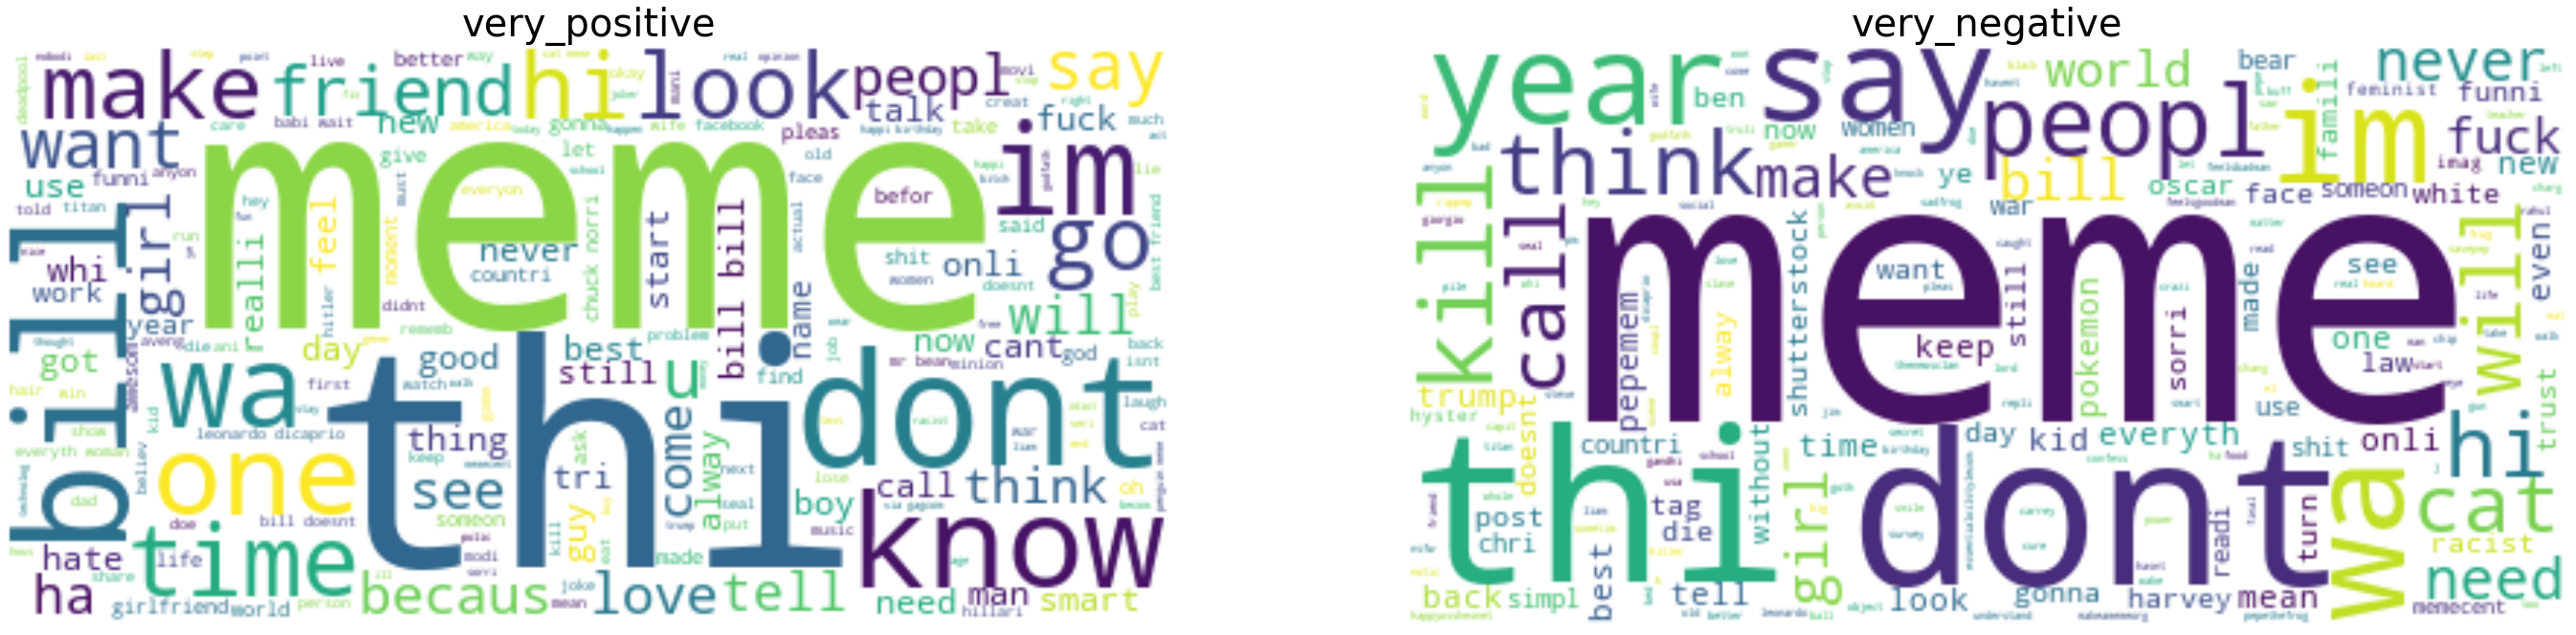

In [52]:
base_word_cloud = base.copy()

tag1 = 'very_positive'
tag2 = 'very_negative'

very_positive = ' '.join(base_word_cloud[base_word_cloud.target == tag1].text).replace("imgflip","").replace("quickmeme","").replace("memegenerator","")
very_negative = ' '.join(base_word_cloud[base_word_cloud.target == tag2].text).replace("imgflip","").replace("quickmeme","").replace("memecenter","")

wordcloud_positive = WordCloud(stopwords=set(STOPWORDS), background_color="white").generate(very_positive)
wordcloud_negative = WordCloud(stopwords=set(STOPWORDS), background_color="white").generate(very_negative)

fig, axs = plt.subplots(1,2, figsize=(48, 16))
axs[0].imshow(wordcloud_positive, interpolation='bilinear')
axs[0].set_title(tag1, fontsize=40)
axs[0].axis("off")
axs[1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1].set_title(tag2, fontsize=40)
plt.axis("off")
plt.show()


**5- É um problema desbalanceado?**



d:\Programas\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Frequencia das classes no conjunto de treinamento (5453 amostras)'}>

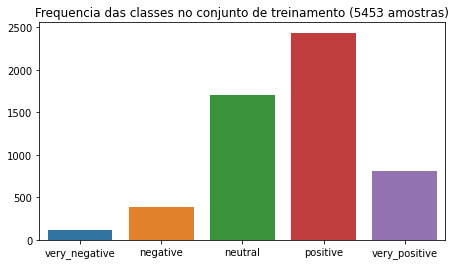

In [53]:
snsPlot = base.copy()
dic_sentiment = {'very_negative': 0, 'negative':1, 'neutral': 2, 'positive':3, 'very_positive': 4} 
snsPlot['sort'] = snsPlot.target.apply(lambda sent : dic_sentiment[sent])
snsPlot = snsPlot.assign(sort=snsPlot.sort.astype(int)).sort_values(by = 'sort').reset_index(drop = True)
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(snsPlot))
labels, counts = np.unique(snsPlot['sort'], return_counts=True)
labels = [x for x in dic_sentiment]
sns.barplot(labels, counts)

É um poblema desbalanceado. 

Usaremos técnincas, por exemplo data augmentation e balanceamento por ponderacao dos pesos para tentar equilibrar as classes desbalanceadas.
Além disso, para a maioria dos modelos será considerado a agregação das classes very_negative e very_positve em negative e positive, respectivamente, constituindo somente três classes (negative, neutral e positive).

**6- Os dados precisarão de algum tipo de pré-processamento?**

R. Sim. Foram removidas linhas NaN, duplicadas e sem registros.

**7- Já há uma divisão entre treino/validação/teste?**

R. Há somente divisão para treino e teste. O conjunto de treinamento será dividido em duas partes:

Primeira parte: 80% para treino.

Segunda parte: 20% para validação.

O conjunto de teste será utilizado no modelo com melhor acurácia balanceada.


**8- Quais as métricas utilizadas neste problema? Acurácia, erro, MSRE, etc.? O que elas significam?**

R. Será utilizado a acurácia balanceada, que basicamente faz o cálculo de todos os acertos (VP e VN) divididos por todos os acertos mais os erros (FP e FN), mas não é influenciada pelo desbalanceamento das classes, porque os cálculos ocorrem em cima da taxa de verdadeiros positivos e verdadeiros negativos.